In [1]:
import mne
from scipy.io import loadmat
import numpy as np

In [2]:
chnames = ['Fp1','Fp2','Fc5','Fz','Fc6','T7','Cz','T8','P7','P3','Pz','P4','P8','O1','Oz','O2','stim']
chtypes = ['eeg'] * 16 + ['stim']
info = mne.create_info(ch_names=chnames, sfreq=512,ch_types=chtypes, montage='standard_1020',verbose=False)
data = loadmat("data/subject_01.mat")["SIGNAL"]

print(data[0])
print(len(data[0]))

[     0.         -16639.796875     1075.2641602    7197.5185547
   1501.6668701   -4080.4909668     872.66534424  -7446.5708008
  -3852.1730957    1030.7530518   -8910.7548828     959.37817383
  -2181.5031738    8054.1430664  -10051.151367    13269.295898
 -19776.359375        0.              0.        ]
19


In [3]:
import matplotlib.pyplot as plt
for k in range(16):
    plt.plot([d[0] for d in data],[d[k] for d in data])
plt.show()

<Figure size 640x480 with 1 Axes>

In [4]:
"""
Colonne 1 : timestamp
Colonne 2 à 17 : les données des 16 éléctrodes
Colonne 18 : quand on passe aux yeux sont fermé
Colone 19 : quand on passe aux yeux sont ouvert
filled with zeros, except at the timestamp corresponding to the beginning of
the block for condition 1 (resp. 2), when the row gets a value of one.
"""

'\nColonne 1 : timestamp\nColonne 2 à 17 : les données des 16 éléctrodes\nColonne 18 : quand on passe aux yeux sont fermé\nColone 19 : quand on passe aux yeux sont ouvert\nfilled with zeros, except at the timestamp corresponding to the beginning of\nthe block for condition 1 (resp. 2), when the row gets a value of one.\n'

In [5]:
#On localise les indices des 1
print("0 : Je ferme les yeux")
for k in range(len(data)):
    if(data[k][17]==1):
        print(str(k)+" : J'ouvre les yeux")
    if(data[k][18]==1):
        print(str(k)+" : Je ferme les yeux")

0 : Je ferme les yeux
35511 : J'ouvre les yeux
45179 : Je ferme les yeux
53413 : J'ouvre les yeux
61886 : Je ferme les yeux
69812 : J'ouvre les yeux
78140 : Je ferme les yeux
85802 : J'ouvre les yeux
93556 : Je ferme les yeux
101416 : J'ouvre les yeux
109193 : Je ferme les yeux


In [6]:
#On modifie pour avoir un dataset avec 1 : yeux ouvert et -1 yeux fermée
new_data=[]
yeux_ouvert=False
for k in range(len(data)):
    if(yeux_ouvert==False):
        tmp=np.append(data[k][1:17],-1)
    else:
        tmp=np.append(data[k][1:17],1)
    new_data.append(tmp)
    if(data[k][17]==1):
        yeux_ouvert=True
    if(data[k][18]==1):
        yeux_ouvert=False

In [7]:
print(len(new_data))
print(len(new_data[0]))

119808
17


In [8]:
nbOuvert=0
nbFermee=0
ens_yeux_fermee=[]
ens_yeux_ouvert=[]
for d in new_data:
    if(d[16]==1):
        nbOuvert+=1
        ens_yeux_ouvert.append(d)
    elif(d[16]==-1):
        nbFermee+=1
        ens_yeux_fermee.append(d)
print(nbOuvert)
print(nbFermee)

42000
77808


In [9]:
min_sample=min(nbOuvert,nbFermee)
print(min_sample)

42000


In [10]:
np.random.shuffle(ens_yeux_fermee)
np.random.shuffle(ens_yeux_ouvert)
ens_yeux_fermee = ens_yeux_fermee[:min_sample]
ens_yeux_ouvert = ens_yeux_ouvert[:min_sample]


In [11]:
print(len(ens_yeux_fermee))
print(len(ens_yeux_ouvert))

42000
42000


In [12]:
data = ens_yeux_fermee+ens_yeux_ouvert
np.random.shuffle(data)
prop=0.8
ens_train=data[:int(len(data)*prop)]
ens_test=data[int(len(data)*prop):]

In [13]:
import pyriemann
from sklearn.model_selection import cross_val_score

In [14]:
labels_train = [d[16] for d in ens_train]
donnees_train = [d[:16] for d in ens_train]

In [20]:
result_acc=[]
for mult in range(1,10):
    #512 Hz
    #On prend 52 trial par échantillon pour avoir un temps de reaction d'environ 0,1015625s
    #On supprime les derniers echantillons pour avoir un multiple de 52 et donc des matrices completes
    nb_trail=mult*17#52
    nb_paquet=int(len(donnees_train)/nb_trail)
    donnees_train = donnees_train[:nb_trail*nb_paquet]
    X=np.array(np.split(np.array(donnees_train), nb_paquet))#Ntrial*Nchannels*Nsample
    print(X.shape)
    X=np.swapaxes(X,1,2)
    print(X.shape)
    #estimer la matrice de covariance
    cov = pyriemann.estimation.Covariances().fit_transform(X)
    #validation croisée
    mdm = pyriemann.classification.MDM()

    #On modifie les y pour qu'il y est qu'un chiffre tout les 52 enregistrement, on prendra dans un premier temps juste
    #le premier label sur les 52 pour estimer les 52 suivant
    labels_train = labels_train[:nb_trail*nb_paquet]
    yTemp = np.array(np.split(np.array(labels_train), nb_paquet))
    y=np.array([u[0] for u in yTemp])
    print(y.shape)
    accuracy = cross_val_score(mdm, cov , y)

    print(accuracy.mean())
    result_acc.append(accuracy.mean())

(3952, 17, 16)
(3952, 16, 17)
(3952,)


/home/nicolas/envPythonML/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.5660371416314188
(1976, 34, 16)
(1976, 16, 34)
(1976,)


/home/nicolas/envPythonML/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.5146779145584556
(1317, 51, 16)
(1317, 16, 51)
(1317,)


/home/nicolas/envPythonML/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.5231812382255482
(987, 68, 16)
(987, 16, 68)
(987,)


/home/nicolas/envPythonML/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.5238066033603138
(789, 85, 16)
(789, 16, 85)
(789,)


/home/nicolas/envPythonML/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.5221799746514575
(657, 102, 16)
(657, 16, 102)
(657,)


/home/nicolas/envPythonML/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.5021784389071055
(563, 119, 16)
(563, 16, 119)
(563,)


/home/nicolas/envPythonML/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.5062578222778473
(492, 136, 16)
(492, 16, 136)
(492,)


/home/nicolas/envPythonML/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.5141782934839946
(437, 153, 16)
(437, 16, 153)
(437,)


/home/nicolas/envPythonML/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.45994331601322624


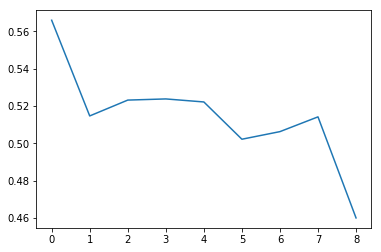

In [22]:
import matplotlib.pyplot as plt
plt.plot(result_acc)
plt.show()